{
  "time": 301.0153166,
  "text": "\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\n\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\n\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\n\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014\u0014",
  "image": ""
}

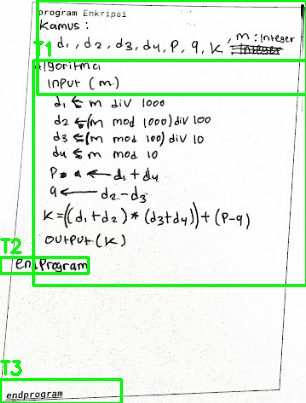

In [2]:
from __future__ import annotations

import base64
import json
import time
from typing import Any, Dict, List, Optional, Tuple

import cv2
import numpy as np
import ollama
from PIL import Image


# ============================================================
# Helpers
# ============================================================

def cv2_to_pil(img_bgr: np.ndarray) -> Image.Image:
    rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb)

def pil_to_png_bytes(img: Image.Image) -> bytes:
    import io
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return buf.getvalue()

def to_data_url_png(img_bgr: np.ndarray) -> str:
    b = pil_to_png_bytes(cv2_to_pil(img_bgr))
    b64 = base64.b64encode(b).decode("utf-8")
    return f"data:image/png;base64,{b64}"

def clamp(v: float, lo: float, hi: float) -> float:
    return max(lo, min(hi, v))

def box_center(box: Tuple[int, int, int, int]) -> Tuple[float, float]:
    x, y, w, h = box
    return (x + w / 2.0, y + h / 2.0)

def box_area(box: Tuple[int, int, int, int]) -> int:
    x, y, w, h = box
    return int(w * h)

def iou(a: Tuple[int, int, int, int], b: Tuple[int, int, int, int]) -> float:
    ax, ay, aw, ah = a
    bx, by, bw, bh = b
    x1 = max(ax, bx)
    y1 = max(ay, by)
    x2 = min(ax + aw, bx + bw)
    y2 = min(ay + ah, by + bh)
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    if inter <= 0:
        return 0.0
    union = aw * ah + bw * bh - inter
    return inter / float(union + 1e-9)


# ============================================================
# OpenCV Preprocess
# ============================================================

def preprocess_for_layout(img_bgr: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    den = cv2.fastNlMeansDenoisingColored(img_bgr, None, 10, 10, 7, 21)
    gray = cv2.cvtColor(den, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    th = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        35, 10
    )

    k = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, k, iterations=1)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k, iterations=1)
    return den, th


# ============================================================
# Detect Text Blocks
# ============================================================

def detect_text_blocks(th: np.ndarray, min_area: int = 700) -> List[Tuple[int, int, int, int]]:
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    merged = cv2.morphologyEx(th, cv2.MORPH_CLOSE, k, iterations=2)
    contours, _ = cv2.findContours(merged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    h_img, w_img = th.shape[:2]
    img_area = w_img * h_img

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if area < min_area or w < 30 or h < 12 or area > 0.85 * img_area:
            continue
        boxes.append((x, y, w, h))

    boxes.sort(key=box_area, reverse=True)
    kept = []
    for b in boxes:
        if all(iou(b, k) < 0.35 for k in kept):
            kept.append(b)

    kept.sort(key=lambda bb: (bb[1], bb[0]))
    return kept


# ============================================================
# Detect Arrow Candidates
# ============================================================

def detect_arrow_candidates(th: np.ndarray) -> List[Tuple[Tuple[int, int, int, int], Tuple[float, float]]]:
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    arrows = []

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 180:
            continue

        x, y, w, h = cv2.boundingRect(cnt)
        if w < 10 or h < 10 or w * h > 30000:
            continue

        pts = cnt.reshape(-1, 2).astype(np.float32)
        if len(pts) < 12:
            continue

        mean = np.mean(pts, axis=0)
        cov = np.cov((pts - mean).T)
        eigvals, eigvecs = np.linalg.eig(cov)
        v = eigvecs[:, int(np.argmax(eigvals))]

        proj = (pts - mean) @ v
        p_min = pts[np.argmin(proj)]
        p_max = pts[np.argmax(proj)]

        dx, dy = float(p_max[0] - p_min[0]), float(p_max[1] - p_min[1])
        norm = (dx * dx + dy * dy) ** 0.5
        if norm < 8:
            continue

        arrows.append(((x, y, w, h), (dx / norm, dy / norm)))

    return arrows


# ============================================================
# Arrow-based ordering
# ============================================================

def nearest_box_in_direction(src, direction, boxes):
    sx, sy = src
    dx, dy = direction
    best_i, best_d = None, 1e9

    for i, b in enumerate(boxes):
        cx, cy = box_center(b)
        vx, vy = cx - sx, cy - sy
        dist = (vx * vx + vy * vy) ** 0.5
        if dist < 10 or dist > 900:
            continue

        dot = (vx / dist) * dx + (vy / dist) * dy
        angle = np.degrees(np.arccos(clamp(dot, -1, 1)))
        if angle > 55:
            continue

        if dist < best_d:
            best_d, best_i = dist, i

    return best_i


def order_boxes_by_arrows(boxes, arrows):
    if not arrows:
        return list(range(len(boxes)))

    edges, incoming = {}, {i: 0 for i in range(len(boxes))}

    for ab, dvec in arrows:
        x, y, w, h = ab
        c = (x + w / 2, y + h / 2)

        before = nearest_box_in_direction(c, (-dvec[0], -dvec[1]), boxes)
        after = nearest_box_in_direction(c, dvec, boxes)

        if before is not None and after is not None and before != after:
            edges[before] = after
            incoming[after] += 1

    order, seen = [], set()
    starts = [i for i in range(len(boxes)) if incoming[i] == 0]

    for s in starts:
        cur = s
        while cur is not None and cur not in seen:
            order.append(cur)
            seen.add(cur)
            cur = edges.get(cur)

    for i in range(len(boxes)):
        if i not in seen:
            order.append(i)

    return order


# ============================================================
# Ollama OCR
# ============================================================

class OllamaBlockOCR:
    def __init__(self, model: str = "llava"):
        self.model = model

    def ocr_text_only(self, img: Image.Image) -> str:
        img_bytes = pil_to_png_bytes(img)

        prompt = (
            "Extract ONLY the pseudocode text from this image.\n"
            "Ignore crossed-out text, Tip-X, scribbles.\n"
            "Preserve line breaks.\n"
            "Return plain text only."
        )

        res = ollama.generate(
            model=self.model,
            prompt=prompt,
            images=[img_bytes],
            options={"temperature": 0}
        )

        return res["response"].strip()


# ============================================================
# Main API
# ============================================================

def extract_pseudocode_with_arrows(
    image_path: str,
    ollama_model: str = "llava",
    return_debug_image: bool = True,
) -> Dict[str, Any]:

    t0 = time.perf_counter()
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(image_path)

    den, th = preprocess_for_layout(img_bgr)
    boxes = detect_text_blocks(th)
    arrows = detect_arrow_candidates(th)
    order = order_boxes_by_arrows(boxes, arrows)

    ocr = OllamaBlockOCR(ollama_model)
    parts = []

    for i in order:
        x, y, w, h = boxes[i]
        crop = den[y:y+h, x:x+w]
        txt = ocr.ocr_text_only(cv2_to_pil(crop))
        if txt:
            parts.append(txt)

    out = {
        "time": time.perf_counter() - t0,
        "text": "\n".join(parts),
        "image": None
    }

    if return_debug_image:
        dbg = img_bgr.copy()
        for i, (x, y, w, h) in enumerate(boxes):
            cv2.rectangle(dbg, (x, y), (x+w, y+h), (0,255,0), 2)
            cv2.putText(dbg, f"T{i}", (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
        out["image"] = to_data_url_png(dbg)

    return out


# ============================================================
# Run Example
# ============================================================

if __name__ == "__main__":
    image_path = r"D:\Python\GENAI\dataset\mahasiswa\if4908_103012500364_nomor1.jpg"

    result = extract_pseudocode_with_arrows(
        image_path=image_path,
        ollama_model="llava",
    )

    print(json.dumps(result, ensure_ascii=False, indent=2))
